# Riconoscimento di animali per auto a guida autonoma#  
VisionTech Solutions vuole sviluppare un sistema di riconoscimento automatico delle immagini per distinguere tra veicoli e animali, con l'obiettivo di ottimizzare le operazioni di monitoraggio della fauna nelle aree urbane, evitando incidenti stradali e proteggendo sia gli animali che i veicoli.

VisionTech Solutions collabora con le amministrazioni comunali per implementare un sistema di monitoraggio in tempo reale nelle città, utilizzando telecamere installate lungo le strade per identificare e classificare veicoli e animali. Questo sistema aiuterà a prevenire incidenti stradali causati dall'attraversamento improvviso di animali, avvisando i guidatori tramite segnali stradali elettronici.

Benefici:

Automazione dei Processi:
Riduzione del tempo e delle risorse per monitorare manualmente le aree urbane.
Rilevamento automatico e in tempo reale di animali e veicoli.
Aumento della Precisione:
Utilizzo di una rete neurale convoluzionale (CNN) per garantire alta precisione nella classificazione delle immagini.
Minimizzazione degli errori umani.
Efficienza Operativa:
Processamento rapido e accurato di grandi volumi di dati, migliorando la risposta agli eventi.
Maggiore sicurezza per i cittadini e riduzione dei danni ai veicoli.
Applicazioni Multiple:
Sorveglianza e monitoraggio del traffico.
Analisi del comportamento animale nelle aree urbane.
Utilizzo dei dati per migliorare le politiche di sicurezza stradale.
Dettagli del Progetto:

Dataset:
Utilizzo del dataset CIFAR, contenente migliaia di immagini etichettate in varie categorie, inclusi veicoli e animali.   
Algoritmo:
Implementazione di una rete neurale convoluzionale (CNN) per l'analisi e la classificazione delle immagini.   
Output:
Il sistema classificherà correttamente ogni immagine come veicolo o animale.   
Valutazione del Modello:

Accuratezza: Proporzione di immagini classificate correttamente rispetto al totale.   
Precisione: Qualità delle predizioni positive, indicando la proporzione di immagini correttamente identificate.   
Analisi dei Risultati:

Identificazione di eventuali pattern di errore.
Valutazione delle categorie di immagini confuse sistematicamente.
Esame delle immagini errate e riflessione su possibili migliorie al modello.   
Risultato Finale:

Presentazione completa della rete neurale convoluzionale e delle sue capacità di discriminazione tra veicoli e animali.
Discussione dettagliata delle metriche utilizzate e un'analisi critica delle prestazioni e limitazioni del modello.
Questo progetto fornirà a VisionTech Solutions un sistema efficace per migliorare la sicurezza stradale e la gestione della fauna nelle aree urbane, dimostrando le competenze pratiche nell'applicazione del machine learning al riconoscimento delle immagini

# Imports

Let's do the necessary imports.  
Using T4 GPU.

In [23]:
!wget -q https://raw.githubusercontent.com/pdimarcodev/AI_Engineering/refs/heads/main/utils/ai_utils.py

In [24]:
from ai_utils import no_warnings
no_warnings()

In [25]:
import os
from google.colab import drive
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.layers import InputLayer, Input, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import MaxPool2D, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Data loading

CIFAR10 dataset contains 50.000 images for training and 10.000 for testing.  
The image shape is 32x32 with 3 layers (RGB).  
The labels are coded with numbers, below are the corresponding labels' meanings.

In [26]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

labels = ['airplane','automobile','bird','cat','deer','dog',\
          'frog','horse','ship','truck']

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [27]:
IMG_SHAPE = (32, 32, 3)

We make a copy of x_test to keep for later evaluations
and convert to float32 to give the necessary precision to the NN input.

In [28]:
x_test_original = np.copy(x_test)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [29]:
y_train, y_test = y_train.flatten(), y_test.flatten()

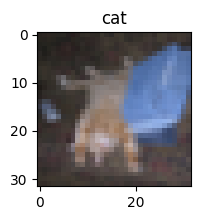

In [30]:
plt.figure(figsize=(2,2))
idx = np.random.choice(range(50000))
plt.imshow(x_train[idx].astype('uint8'))
plt.title(labels[y_train[idx]]);

Images are pixeled with very low definition.  

We have to re-categorize the labels into 2 categories: animal and vehicle.

Using a mask to do it more efficiently.

In [31]:
new_labels = {0: 'animal', 1: 'vehicle'}

In [32]:
vehicle_labels = ['airplane','automobile','ship','truck']
vehicle_indices = [labels.index(l) for l in vehicle_labels]

y_train_masked = np.full(y_train.shape, 0)
y_test_masked = np.full(y_test.shape, 0)

y_train_masked[np.isin(y_train, vehicle_indices)] = 1
y_test_masked[np.isin(y_test, vehicle_indices)] = 1

y_train, y_test = y_train_masked, y_test_masked

In [33]:
y_train.shape

(50000,)

In [34]:
y_test.shape

(10000,)

let's check real quick.

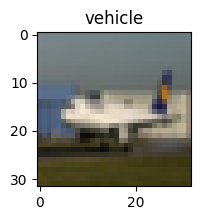

In [35]:
plt.figure(figsize=(2,2))
idx = np.random.choice(range(50000))
plt.imshow(x_train[idx].astype('uint8'))
plt.title(new_labels[y_train[idx]]);

In [36]:
print(f"Number of animal samples in training: {np.sum(y_train == 0)}")
print(f"Number of vehicle samples in training: {np.sum(y_train == 1)}")

Number of animal samples in training: 30000
Number of vehicle samples in training: 20000


# 1. Transfer learning

First, let's try applying transfer learning by using [MobileNetV3 Large](https://keras.io/api/applications/mobilenet/).  
V3 does by default the preprocessing to scale pixel values, that saves us that step.  
Excluding the top to remove last layers.
Using weights pretrained on ImageNet.

Let's define a frozen base model.



In [37]:
base_model = MobileNetV3Large(input_shape=IMG_SHAPE,
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False
print(f"Number of layers in the base model: {len(base_model.layers)}")

Number of layers in the base model: 187


To the non trainable base model we add the last layers:
a pooling layer and a dropout for regularization.  
Finally, because we're dealing with a binary classification,
the output is one neuron with sigmoid activation.

In [38]:
inputs = Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

outputs = Dense(1, activation='sigmoid')(x)

In [39]:
clear_session()

model = Model(inputs, outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 1, 1, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       246,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,276,929 (12.50 MB)

 Trainable params: 279,809 (1.07 MB)

 Non-trainable params: 2,997,120 (11.43 MB)

In [40]:
for layer in model.layers:
  print(f"Layer name: {layer.name}, Trainable: {layer.trainable}")

Layer name: input_layer_1, Trainable: True
Layer name: MobileNetV3Large, Trainable: False
Layer name: global_average_pooling2d, Trainable: True
Layer name: dense, Trainable: True
Layer name: batch_normalization, Trainable: True
Layer name: dropout, Trainable: True
Layer name: dense_1, Trainable: True
Layer name: batch_normalization_1, Trainable: True
Layer name: dropout_1, Trainable: True
Layer name: dense_2, Trainable: True


Compile the model using Adam optimizer (it works well for this),
the corresponding loss for binary classification and
add some metrics, including AUC because of the class imbalance not affecting this metric.

By adding callbacks we:
* monitor *val_loss* in order to reduce the learning rate (by factor and with a minimum) if it stops decreasing for a number of epochs (patience).
* set an early stopper also monitoring *val_loss*, stopping the training after 15 epochs of no improvement.


In [41]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', AUC(name='auc')])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)

## Training

this batch size works better after some pre-testing done.

In [42]:
EPOCHS = 100
BATCH_SIZE = 64

history = model.fit(x_train,
                    y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(x_test, y_test),
                    callbacks=[reduce_lr, early_stopping])

Epoch 1/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 75s 82ms/step - accuracy: 0.7406 - auc: 0.8024 - loss: 0.5804 - val_accuracy: 0.8110 - val_auc: 0.8915 - val_loss: 0.4065 - learning_rate: 0.0010
Epoch 2/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 58s 74ms/step - accuracy: 0.8152 - auc: 0.8920 - loss: 0.4053 - val_accuracy: 0.8204 - val_auc: 0.9003 - val_loss: 0.3901 - learning_rate: 0.0010
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 78s 99ms/step - accuracy: 0.8286 - auc: 0.9033 - loss: 0.3846 - val_accuracy: 0.8256 - val_auc: 0.9046 - val_loss: 0.3820 - learning_rate: 0.0010
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 61s 79ms/step - accuracy: 0.8321 - auc: 0.9103 - loss: 0.3702 - val_accuracy: 0.8280 - val_auc: 0.9060 - val_loss: 0.3803 - learning_rate: 0.0010
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 59s 75ms/step - accuracy: 0.8429 - auc: 0.9172 - loss: 0.3579 - val_accuracy: 0.8307 - val_auc: 0.9091 - val_loss: 0.3737 - learning_rate: 0.0010
Epoch 6/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 72s 92ms/step - accuracy

In [43]:
def evaluate_model(x_test, y_test, model, history):

  print("\nEvaluating on test data:")
  loss, accuracy, auc = model.evaluate(x_test, y_test, verbose=0)
  print(f"Test Loss: {loss:.4f}")
  print(f"Test Accuracy: {accuracy:.4f}")
  print(f"Test AUC: {auc:.4f}")

  # Plot training history
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 3, 1)
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Val Loss')
  plt.legend()
  plt.title('Loss')

  plt.subplot(1, 3, 2)
  plt.plot(history.history['accuracy'], label='Train Accuracy')
  plt.plot(history.history['val_accuracy'], label='Val Accuracy')
  plt.legend()
  plt.title('Accuracy')

  plt.subplot(1, 3, 3)
  plt.plot(history.history['auc'], label='Train AUC')
  plt.plot(history.history['val_auc'], label='Val AUC')
  plt.legend()
  plt.title('AUC')

  plt.tight_layout()
  plt.show()

  # predictions on the test set
  predictions = model.predict(x_test)
  predicted_labels = (predictions > 0.5).astype(int).flatten()

  # incorrect predictions
  incorrect_indices = np.where(predicted_labels != y_test)[0]
  print(f"Number of misclassified images: {len(incorrect_indices)}")

  # show some misclassified images
  num_to_show = 10

  print(f"\nShowing the first {min(num_to_show, len(incorrect_indices))} misclassified images:")

  for i in range(min(num_to_show, len(incorrect_indices))):
      idx = incorrect_indices[i]
      true_label_int = y_test[idx]
      predicted_label_int = predicted_labels[idx]
      confidence = predictions[idx][0]

      true_label_str = new_labels[true_label_int]
      predicted_label_str = new_labels[predicted_label_int]

      img_display = x_test_original[idx].astype('uint8')

      plt.figure(figsize=(3, 3))
      plt.imshow(img_display)
      plt.title(f"True: {true_label_str}, Pred: {predicted_label_str}\nConfidence: {confidence:.4f}")
      plt.axis('off')
      plt.show()

      # categorize errors
      if true_label_str == 'animal' and predicted_label_str == 'vehicle':
          print(f"Image {idx}: Animal misclassified as Vehicle (Confidence: {confidence:.4f})")
      elif true_label_str == 'vehicle' and predicted_label_str == 'animal':
          print(f"Image {idx}: Vehicle misclassified as Animal (Confidence: {confidence:.4f})")

  # Confusion matrix
  cm = confusion_matrix(y_test, predicted_labels)

  plt.figure(figsize=(6, 5))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=new_labels.values(), yticklabels=new_labels.values())
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title('Confusion Matrix')
  plt.show()



Evaluating on test data:
Test Loss: 0.3677
Test Accuracy: 0.8358
Test AUC: 0.9125


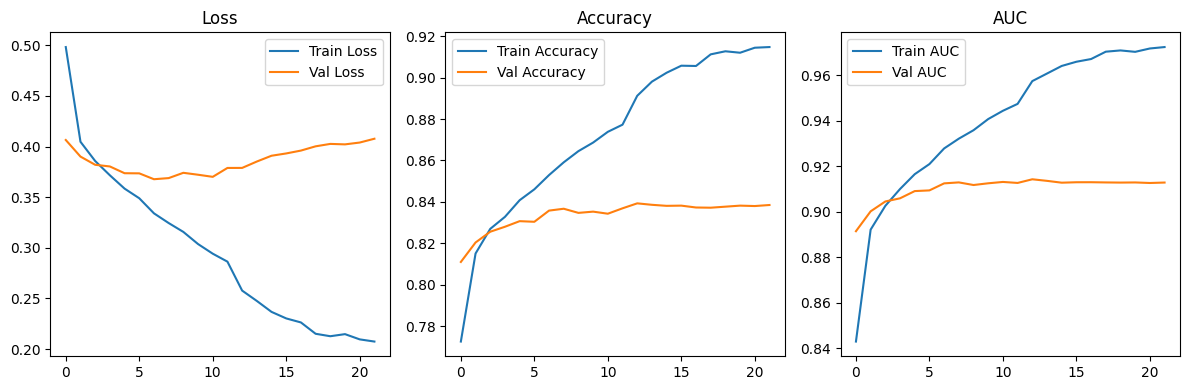

313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step
Number of misclassified images: 1642

Showing the first 10 misclassified images:


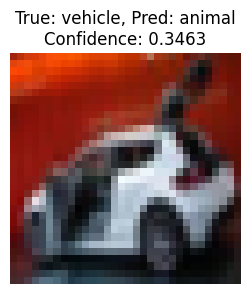

Image 6: Vehicle misclassified as Animal (Confidence: 0.3463)


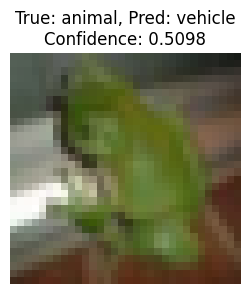

Image 7: Animal misclassified as Vehicle (Confidence: 0.5098)


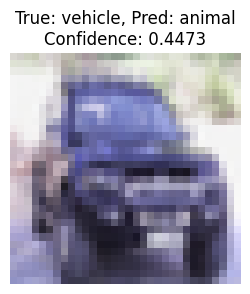

Image 9: Vehicle misclassified as Animal (Confidence: 0.4473)


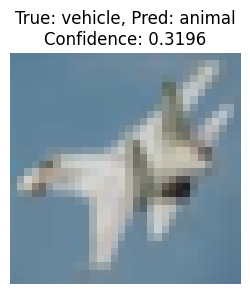

Image 10: Vehicle misclassified as Animal (Confidence: 0.3196)


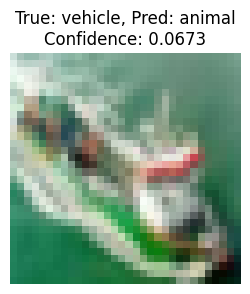

Image 15: Vehicle misclassified as Animal (Confidence: 0.0673)


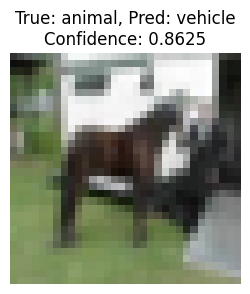

Image 20: Animal misclassified as Vehicle (Confidence: 0.8625)


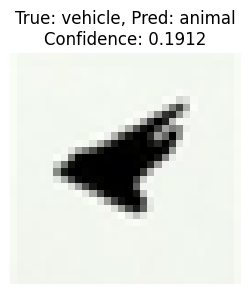

Image 21: Vehicle misclassified as Animal (Confidence: 0.1912)


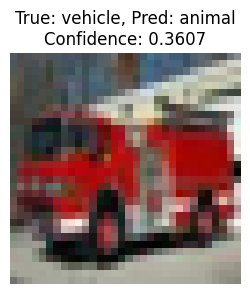

Image 23: Vehicle misclassified as Animal (Confidence: 0.3607)


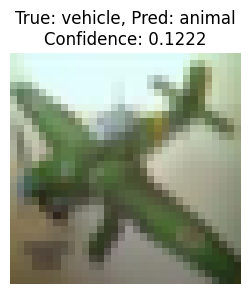

Image 27: Vehicle misclassified as Animal (Confidence: 0.1222)


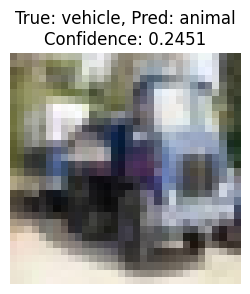

Image 28: Vehicle misclassified as Animal (Confidence: 0.2451)


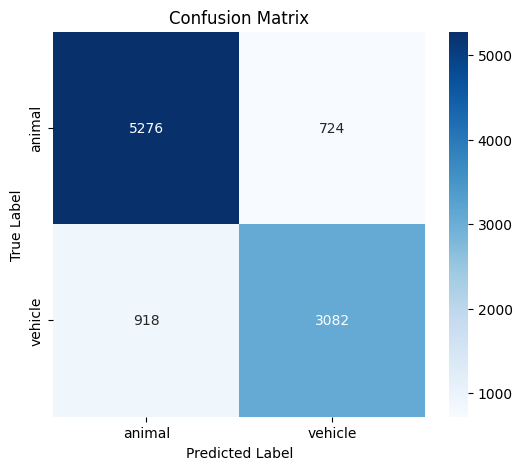

In [44]:
evaluate_model(x_test, y_test, model, history)

## Conclusion Model #1

Test Loss: 0.3677    
Test Accuracy: 0.8358  
Test AUC: 0.9125

The model didn't perform well with new data, noticing by seeing the training logs that accuracy overperformed on already trained data.   
This level of accuracy is not acceptable for the purpose of this model.

# 2. Custom model

Now let's try a custom model with a standard CNN structure.

We use the default Glorot initializer.  

In the Conv2D layers we start with 32 filters (kernels) repeatedly, then we go deeper with more, with a kernel size of 3x3.

Pooling does the downsampling, by taking the maximum value within a moving 2x2 window.

When performing a convolution operation, the size of the output feature map can be smaller than the input image (or previous layer's output). padding='same' is a technique used to ensure that the output feature map has the same spatial dimensions (height and width) as the input. It achieves this by adding zeros around the borders of the input image before performing the convolution.  

Dropout Rate (0.3): means that 30% of the neurons in that layer will be randomly deactivated during each training step, to prevent overfitting. Later is higher (0.5) because the network is more complex to avoid potential co-dependent features.

Batch Normalization is applied to the outputs of a layer to standardize the inputs to the next layer.

As before, we use a sigmoid activation function.






Now we need to scale pixel values:

In [28]:
x_train /= 255.0
x_test /= 255.0

In [29]:
clear_session()

model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=IMG_SHAPE),
    BatchNormalization(),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.5),

    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.5),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 551,713 (2.10 MB)

 Trainable params: 550,561 (2.10 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [31]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', AUC(name='auc')])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)

## Training

In [32]:
EPOCHS = 100
BATCH_SIZE = 64

start_time = time.time()

history = model.fit(x_train,
                    y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(x_test, y_test),
                    callbacks=[reduce_lr, early_stopping]
                    )

Epoch 1/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 21ms/step - accuracy: 0.8491 - auc: 0.9176 - loss: 0.3753 - val_accuracy: 0.9028 - val_auc: 0.9729 - val_loss: 0.2357 - learning_rate: 0.0010
Epoch 2/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.9167 - auc: 0.9715 - loss: 0.2092 - val_accuracy: 0.8482 - val_auc: 0.9721 - val_loss: 0.3639 - learning_rate: 0.0010
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9306 - auc: 0.9783 - loss: 0.1807 - val_accuracy: 0.9249 - val_auc: 0.9835 - val_loss: 0.1946 - learning_rate: 0.0010
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9359 - auc: 0.9819 - loss: 0.1652 - val_accuracy: 0.9139 - val_auc: 0.9809 - val_loss: 0.2203 - learning_rate: 0.0010
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9431 - auc: 0.9860 - loss: 0.1455 - val_accuracy: 0.9474 - val_auc: 0.9882 - val_loss: 0.1393 - learning_rate: 0.0010
Epoch 6/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.94

In [33]:
end_time = time.time()

print(f"Model training took {end_time - start_time:.2f} seconds")

Model training took 377.63 seconds



Evaluating on test data:
Test Loss: 0.0719
Test Accuracy: 0.9744
Test AUC: 0.9955


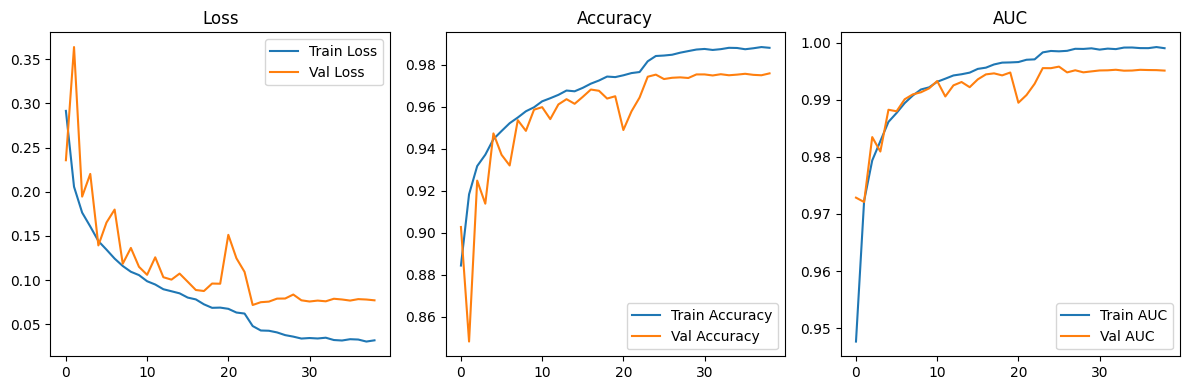

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Number of misclassified images: 256

Showing the first 10 misclassified images:


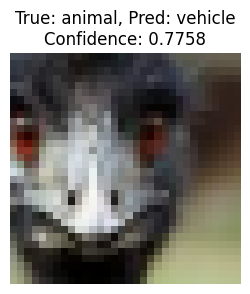

Image 35: Animal misclassified as Vehicle (Confidence: 0.7758)


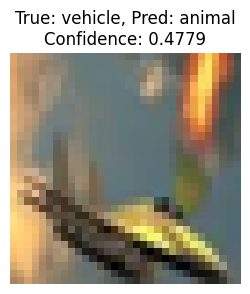

Image 125: Vehicle misclassified as Animal (Confidence: 0.4779)


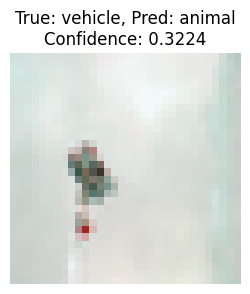

Image 313: Vehicle misclassified as Animal (Confidence: 0.3224)


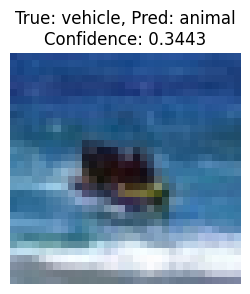

Image 368: Vehicle misclassified as Animal (Confidence: 0.3443)


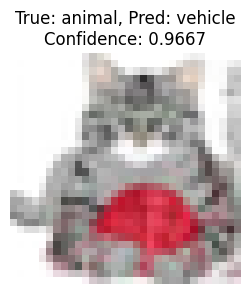

Image 399: Animal misclassified as Vehicle (Confidence: 0.9667)


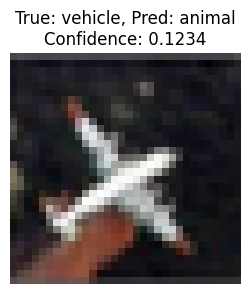

Image 423: Vehicle misclassified as Animal (Confidence: 0.1234)


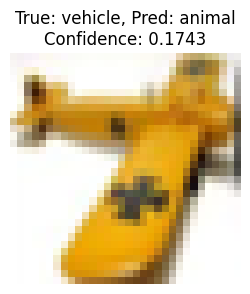

Image 678: Vehicle misclassified as Animal (Confidence: 0.1743)


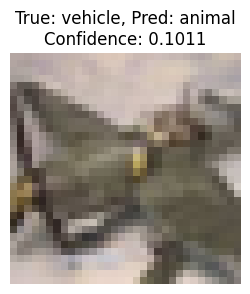

Image 689: Vehicle misclassified as Animal (Confidence: 0.1011)


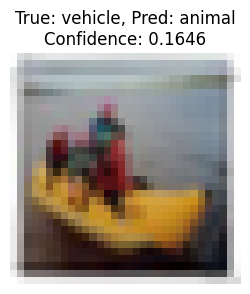

Image 717: Vehicle misclassified as Animal (Confidence: 0.1646)


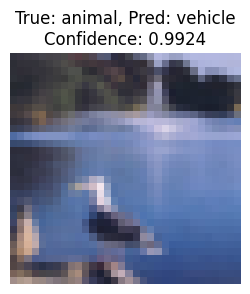

Image 725: Animal misclassified as Vehicle (Confidence: 0.9924)


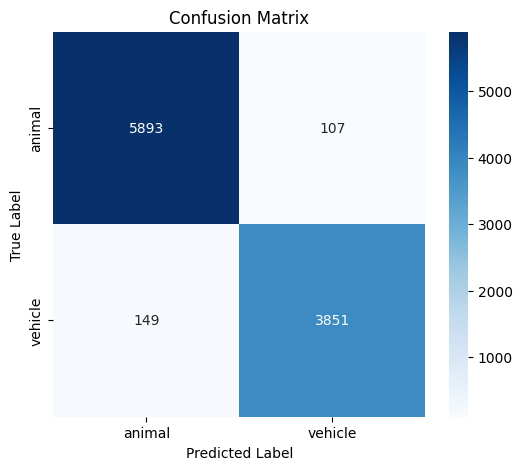

In [34]:
evaluate_model(x_test, y_test, model, history)

## Conclusion Model #2

Test Loss: 0.0719  
Test Accuracy: 0.9744  
Test AUC: 0.9955  

The model did pretty well on the test set,
with **accuracy=97.4%** and **AUC=99.55%**

It classified 149 vehicles as animals, and 107 animals as vehicles.

Regarding the mismatched images, in general we can say that for example,
it can confuse an airplane with a bird, vehicle lights with animal eyes, I guess. Given that we're dealing with low resolution pictures,
that doesn't help to distinguish properly between the categories.

In [35]:
def save_model_to_drive(model, filename):
  ROOT = '/content/drive'

  if not os.path.exists(ROOT):
    drive.mount('/content/drive')

  PATH = ROOT + "/My Drive/Colab_Models/"

  if not os.path.exists(PATH):
    os.makedirs(PATH)
    print(f"Created directory: {PATH}")


  model.save(PATH + "filename" + ".keras")
  print(f"\nModel saved to: {os.path.abspath(PATH)}")

In [36]:
save_model_to_drive(model, "cifar10_custom_model")

Mounted at /content/drive

Model saved to: /content/drive/My Drive/Colab_Models


# 3. Data augmentation

Let's try another approach to see if we can improve the model by tweaking randomly images.  
Regarding zoom, doing only zoom out to avoid definition losses.  

We don't need to call datagen.fit() unless we are using
featurewise_center, featurewise_std_normalization, or zca_whitening.







In [37]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=[0.8, 1.0],
    horizontal_flip=True,
    fill_mode='nearest'
)

In [38]:
clear_session()

model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=IMG_SHAPE),
    BatchNormalization(),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), padding='same', activation='relu'), r
    BatchNormalization(),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 551,713 (2.10 MB)

 Trainable params: 550,561 (2.10 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [39]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', AUC(name='auc')])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)

In [40]:
BATCH_SIZE = 64
EPOCHS = 100

train_generator = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)

history = model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_test, y_test),
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/100
781/781 ━━━━━━━━━━━━━━━━━━━━ 53s 51ms/step - accuracy: 0.8400 - auc: 0.9092 - loss: 0.3972 - val_accuracy: 0.8954 - val_auc: 0.9589 - val_loss: 0.2681 - learning_rate: 0.0010
Epoch 2/100
781/781 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9375 - auc: 0.9823 - loss: 0.1705 - val_accuracy: 0.8949 - val_auc: 0.9577 - val_loss: 0.2714 - learning_rate: 0.0010
Epoch 3/100
781/781 ━━━━━━━━━━━━━━━━━━━━ 33s 43ms/step - accuracy: 0.8984 - auc: 0.9591 - loss: 0.2518 - val_accuracy: 0.9041 - val_auc: 0.9778 - val_loss: 0.2294 - learning_rate: 0.0010
Epoch 4/100
781/781 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9375 - auc: 0.9737 - loss: 0.1953 - val_accuracy: 0.9050 - val_auc: 0.9779 - val_loss: 0.2239 - learning_rate: 0.0010
Epoch 5/100
781/781 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.9127 - auc: 0.9688 - loss: 0.2185 - val_accuracy: 0.9341 - val_auc: 0.9815 - val_loss: 0.1682 - learning_rate: 0.0010
Epoch 6/100
781/781 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.89

In [41]:
end_time = time.time()

print(f"Model training took {end_time - start_time:.2f} seconds")

Model training took 2083.99 seconds



Evaluating on test data:
Test Loss: 0.0909
Test Accuracy: 0.9651
Test AUC: 0.9945


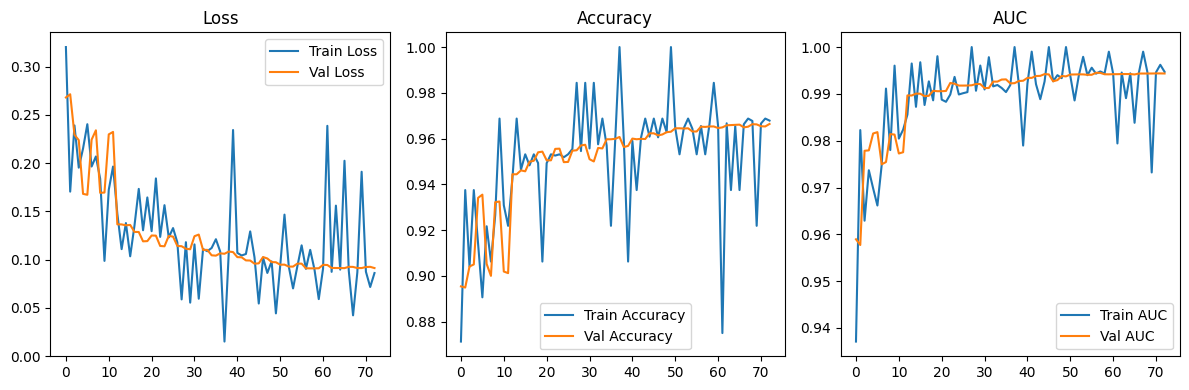

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Number of misclassified images: 349

Showing the first 10 misclassified images:


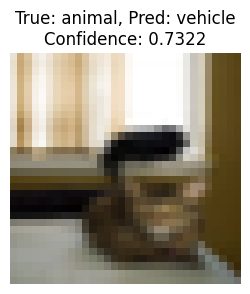

Image 63: Animal misclassified as Vehicle (Confidence: 0.7322)


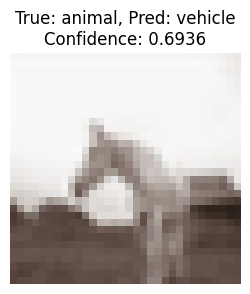

Image 87: Animal misclassified as Vehicle (Confidence: 0.6936)


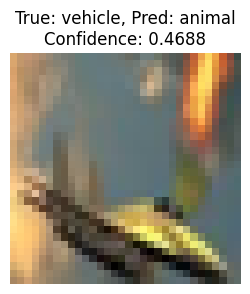

Image 125: Vehicle misclassified as Animal (Confidence: 0.4688)


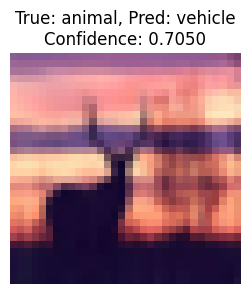

Image 211: Animal misclassified as Vehicle (Confidence: 0.7050)


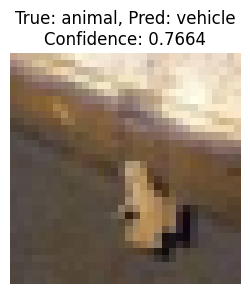

Image 226: Animal misclassified as Vehicle (Confidence: 0.7664)


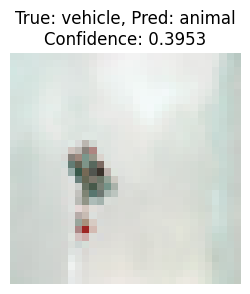

Image 313: Vehicle misclassified as Animal (Confidence: 0.3953)


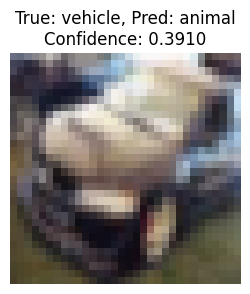

Image 325: Vehicle misclassified as Animal (Confidence: 0.3910)


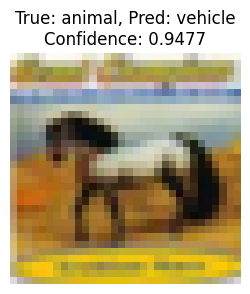

Image 339: Animal misclassified as Vehicle (Confidence: 0.9477)


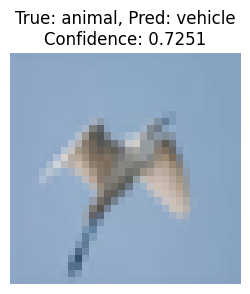

Image 342: Animal misclassified as Vehicle (Confidence: 0.7251)


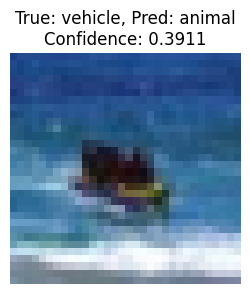

Image 368: Vehicle misclassified as Animal (Confidence: 0.3911)


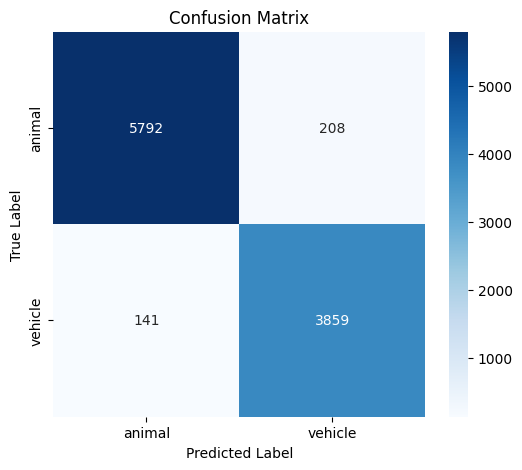

In [42]:
evaluate_model(x_test, y_test, model, history)

In [43]:
save_model_to_drive(model, "cifar10_custom_augmented_model")


Model saved to: /content/drive/My Drive/Colab_Models


# Conclusion Model #3

Test Loss: 0.0909  
Test Accuracy: 0.9651  
Test AUC: 0.9945  

The model did pretty well, but still Model #2 did better.  
During the training we notice spiky flipping metrics, Model #2 has more stable curves.  
We'll suggest to continue training that model and doing fine-tuning.


Pablo Di Marco - 02-Jun-2025